# A Deep Learning Model for Reading Sequential Numbers on Pictures: Optical Character Recognation (OCR)

## developed by Ahmet Altun

### Task

The objective is to build and train a deep learning model using TensorFlow to recognize five-digit numbers from images. The task involves creating a synthetic dataset with 180,000 samples, split into training, validation, and test sets, each accompanied by their corresponding labels. Specifically, the model constructed will combine a Convolutional Recurrent Neural Network (CRNN) with Long Short-Term Memory (LSTM) layers to effectively capture both spatial and sequential patterns in the data.

### Importing Necessary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras import layers, losses, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
import pickle
import random
import os

In [2]:
# Ignoring filter warnings
import warnings            
warnings.filterwarnings("ignore") 

In [3]:
# Library versions
print(f"Tensorflow Version: {tf.__version__}\nNumpy Version: {np.__version__}")

Tensorflow Version: 2.12.0
Numpy Version: 1.23.5


### Creating the Dataset

***Defining constants***

In [4]:
DATASET_SIZE = 180000
TRAIN_SIZE = 60000
VALIDATION_SIZE = 60000
TEST_SIZE = 60000
NUM_DIGITS = 5  # the number of digits in the plate 
NUM_CLASSES = 10  # the number of classes for each digit (numbers between 0 and 9)
PLATE_WIDTH = 100
PLATE_HEIGHT = 50
FONT_LIST = [cv2.FONT_HERSHEY_SIMPLEX, cv2.FONT_HERSHEY_DUPLEX, cv2.FONT_HERSHEY_TRIPLEX]
FONT_SCALE_RANGE = (0.75, 1)
FONT_THICKNESS_RANGE = (1, 2)
NOISE_LEVEL = 0.05

***Defining augmenter for data augmentation***

In [5]:
augmenter = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10), scale=(0.9, 1.1)),
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
    iaa.AdditiveGaussianNoise(scale=NOISE_LEVEL * 255),
    iaa.EdgeDetect(alpha=(0.0, 0.5))
])

***Generating and saving artificial samples and their labels***

In [6]:
# Setting seed for reproducibility
random.seed(42)
np.random.seed(42)

# Defining the directory paths
output_dir = "dataset"
train_dir = os.path.join(output_dir, "train_set")
validation_dir = os.path.join(output_dir, "validation_set")
test_dir = os.path.join(output_dir, "test_set")

# Creating the directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Creating a blank plate
blank_plate = np.ones((PLATE_HEIGHT, PLATE_WIDTH), dtype=np.uint8) * 255

# Initializing labels
y_train = []
y_val = []
y_test = []

# Initializing samples
X_train = []
X_val = []
X_test = []

# Counter for file indexing
train_counter = 0
validation_counter = 0
test_counter = 0

# Sample Generation
for i in range(DATASET_SIZE):
    # Generating random numbers
    numbers = [random.randint(0, 9) for _ in range(NUM_DIGITS)]
    
    # Randomizing font, font scale, and font thickness
    font = random.choice(FONT_LIST)
    font_scale = random.uniform(*FONT_SCALE_RANGE)
    font_thickness = random.randint(*FONT_THICKNESS_RANGE)

    # Adding numbers to the plate image
    plate = blank_plate.copy()
    for j, num in enumerate(numbers):
        num_str = str(num)
        text_size = cv2.getTextSize(num_str, font, font_scale, font_thickness)[0]
        x = int((PLATE_WIDTH / NUM_DIGITS) * j + (PLATE_WIDTH / NUM_DIGITS - text_size[0]) / 2)
        y = int((PLATE_HEIGHT - text_size[1]) / 2 + text_size[1])
        cv2.putText(plate, num_str, (x, y), font, font_scale, 0, font_thickness)

    # Applying data augmentation
    plate_augmented = augmenter(image=plate)

    # Applying noise to the border of the letters
    noise = np.random.normal(scale=NOISE_LEVEL, size=plate_augmented.shape).astype(np.uint8)
    plate_augmented = cv2.add(plate_augmented, noise)

    # Converting the plate image to NumPy array
    plate_array = np.array(plate_augmented)

    # Saving the plate image with the corresponding label
    filename = f"{i}.png"  # Update the filename convention
    
    if i < TRAIN_SIZE:
        cv2.imwrite(os.path.join(train_dir, f"{train_counter}.png"), plate_augmented)
        X_train.append(plate_array)
        y_train.append(numbers)
        train_counter += 1
    elif i < TRAIN_SIZE + VALIDATION_SIZE:
        cv2.imwrite(os.path.join(validation_dir, f"{validation_counter}.png"), plate_augmented)
        X_val.append(plate_array)
        y_val.append(numbers)
        validation_counter += 1
    else:
        cv2.imwrite(os.path.join(test_dir, f"{test_counter}.png"), plate_augmented)
        X_test.append(plate_array)
        y_test.append(numbers)
        test_counter += 1

# Converting lists to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Saving images and labels as NumPy arrays
np.save(os.path.join(train_dir, "X_train.npy"), X_train)
np.save(os.path.join(validation_dir, "X_val.npy"), X_val)
np.save(os.path.join(test_dir, "X_test.npy"), X_test)
np.save(os.path.join(train_dir, "y_train.npy"), y_train)
np.save(os.path.join(validation_dir, "y_val.npy"), y_val)
np.save(os.path.join(test_dir, "y_test.npy"), y_test)

***Loading datasets***

In [7]:
# Loading the training dataset
X_train_load = np.load(os.path.join("dataset/train_set/X_train.npy"))
y_train_load = np.load(os.path.join("dataset/train_set/y_train.npy"))

# Loading the validation dataset
X_val_load = np.load(os.path.join("dataset/validation_set/X_val.npy"))
y_val_load = np.load(os.path.join("dataset/validation_set/y_val.npy"))

# Loading the test dataset
X_test_load = np.load(os.path.join("dataset/test_set/X_test.npy"))
y_test_load = np.load(os.path.join("dataset/test_set/y_test.npy"))

***Viewing randomly selected plates and their labels***

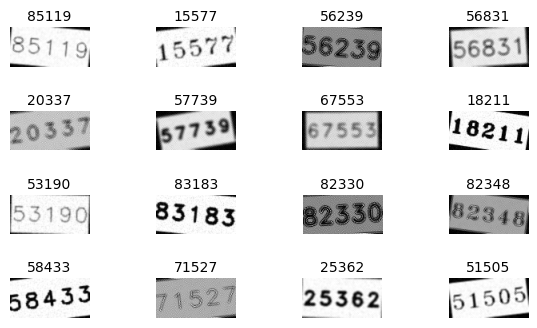

In [8]:
# Randomly select of 16 training images
random_indices = random.sample(range(len(y_train_load)), 16)

# Creating a subplot with 4 rows and 4 columns
fig, axes = plt.subplots(4, 4, figsize=(6, 3.5))
fig.tight_layout()

# Iterating over the selected images
for i, idx in enumerate(random_indices):
    # Getting the image from X_train
    image = X_train_load[idx]

    # Getting the corresponding label
    label = y_train_load[idx]

    # Converting the label to a string
    label_str = "".join(str(num) for num in label)

    # Plotting the image and label
    ax = axes[i // 4, i % 4]
    ax.imshow(image, cmap="gray")
    ax.axis("off")
    ax.set_title(label_str, fontsize=10, pad=5)

# Showing the plot
plt.show()

### Data Preprocessing

In [9]:
# Scaling, reshaping, and saving as tf tensor
X_train = tf.convert_to_tensor((X_train_load / 255.0).astype("float32").reshape(-1, 50, 100, 1))
X_val = tf.convert_to_tensor((X_val_load / 255.0).astype("float32").reshape(-1, 50, 100, 1))
X_test = tf.convert_to_tensor((X_test_load / 255.0).astype("float32").reshape(-1, 50, 100, 1))

y_train = tf.convert_to_tensor(y_train_load, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val_load, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test_load, dtype=tf.int32)

# One-hot encoding of labels
y_train_encoded = tf.one_hot(y_train, NUM_CLASSES)
y_val_encoded = tf.one_hot(y_val, NUM_CLASSES)
y_test_encoded = tf.one_hot(y_test, NUM_CLASSES)

In [10]:
# Adding one extra dimension to one-hot encoded labels for more stable LMST processing
input_dim = (PLATE_HEIGHT, PLATE_WIDTH, 1)  # Input image dimensions
output_dim = (5, 11)  # Increased dimension for separation between digits
num_classes_modified = y_train_encoded.shape[2] + 1

y_train_modified = np.zeros((y_train_encoded.shape[0], y_train_encoded.shape[1], num_classes_modified))
y_train_modified[:, :, :-1] = y_train_encoded
y_train_modified[:, :, -1] = np.all(y_train_encoded == 0, axis=-1)

y_val_modified = np.zeros((y_val_encoded.shape[0], y_val_encoded.shape[1], num_classes_modified))
y_val_modified[:, :, :-1] = y_val_encoded
y_val_modified[:, :, -1] = np.all(y_val_encoded == 0, axis=-1)

y_test_modified = np.zeros((y_test_encoded.shape[0], y_test_encoded.shape[1], num_classes_modified))
y_test_modified[:, :, :-1] = y_test_encoded
y_test_modified[:, :, -1] = np.all(y_test_encoded == 0, axis=-1)

### Defining the Model Architecture

The proposed model architecture in the following combines the strengths of a Convolutional Recurrent Neural Network (CRNN) and Long Short-Term Memory (LSTM) layers. The CRNN architecture involves stacking convolutional layers with increasing filter sizes to extract spatial features from the license plate images. These convolutional layers are followed by batch normalization, dropout, and max pooling operations, enabling the model to effectively capture important spatial patterns. The LSTM layers, on the other hand, are responsible for modeling sequential dependencies by analyzing the temporal information present in the license plate numbers. Additionally, L2 kernel regularization is applied to prevent overfitting and improve generalization by controlling the complexity of the model based on the magnitudes of the kernel weights.

In [11]:
input_dim = (PLATE_HEIGHT, PLATE_WIDTH, 1)
output_dim = (NUM_DIGITS, NUM_CLASSES+1)

model = models.Sequential()

# CNN layers
model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        padding='same', input_shape=input_dim, 
                        kernel_regularizer=l2(0.002)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        padding='same', kernel_regularizer=l2(0.002)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        padding='same', kernel_regularizer=l2(0.002)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        padding='same', kernel_regularizer=l2(0.002)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Reshape the last layer before LSTM
model.add(layers.Reshape((input_dim[0] // 16, input_dim[1] // 16 * 128)))

# LSTM layers
model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(256)))

# Additional fully connected layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

# Output layer
model.add(layers.Dense(np.prod(output_dim), activation='softmax'))
model.add(layers.Reshape(output_dim))

### Defining Checkpoint

In [12]:
# Defining the checkpoint filename
checkpoint_path = "model_checkpoint.h5"

# Creating a checkpoint callback to save the optimizer state
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=False,
                             save_best_only=True,
                             save_format='h5')

### Compiling the Model

In [13]:
model.compile(optimizer=Adam(learning_rate=0.0005), loss="categorical_crossentropy", metrics=['accuracy'])    

### Training the Model

I conducted an intensive trial process to construct the optimal model architecture and parameters. Here are the key findings:

**1)** To prevent overfitting, L2 kernel regularization, dropout layers, and batch sizes larger than 32 are all essential.

**2)** An "incremental training" procedure was used to efficiently train the model. I started with a small portion of the training and validation sets, and then gradually increased their sizes along with the batch size. This approach, involving different subsets, was instrumental in preventing overfitting and ensuring the model's robustness.

**3)** For final tuning, I utilized the complete training and validation sets, each consisting of 60 000 samples.

**4)** The best-performing model was saved in the checkpoint file "model_checkpoint.h5".

### Final Fitting of the Model

***Loading the model constructed***

In [14]:
model = load_model("model_checkpoint.h5")

***Fitting the model on the entire training set***

In [15]:
# Setting random seed for reproducibility
tf.random.set_seed(42)

# Defining batch size
BATCH_SIZE = 2000

# Fitting the model
history = model.fit(X_train, y_train_modified, 
                    validation_data=(X_val, y_val_modified),
                    batch_size=BATCH_SIZE, 
                    epochs=5,
                    callbacks=[checkpoint])

Epoch 1/5
30/30 [==============================] - 503s 17s/step - loss: 0.3032 - accuracy: 0.8950 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 2/5
30/30 [==============================] - 530s 18s/step - loss: 0.3057 - accuracy: 0.8938 - val_loss: 0.0086 - val_accuracy: 0.9999
Epoch 3/5
30/30 [==============================] - 519s 17s/step - loss: 0.3054 - accuracy: 0.8947 - val_loss: 0.0083 - val_accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 614s 21s/step - loss: 0.3035 - accuracy: 0.8944 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 5/5
30/30 [==============================] - 531s 18s/step - loss: 0.3046 - accuracy: 0.8940 - val_loss: 0.0080 - val_accuracy: 1.0000


### Accuracy Assesment

***Accuracy metrics with `fit()` and `evaluate()` methods of Keras/Tensorflow***

Let's plot accuracy metrics obtained with the `fit()` method wrt. epochs in the above run.

In [16]:
# Saving the history to a file to be able to access it later.
with open("history.pickle", "wb") as file:
    pickle.dump(history, file)

In [17]:
# Loading the saved history
with open("history.pickle", "rb") as file:
    history = pickle.load(file)

Text(0, 0.5, 'Loss / Accuracy')

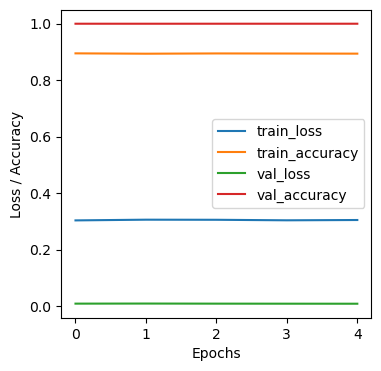

In [18]:
# Converting history to a dataframe
history_df = pd.DataFrame(history)

# Renaming columns
history_df = history_df.rename(columns={'loss': 'train_loss', 'accuracy': 'train_accuracy'})

# Plotting the metrics
ax = history_df.plot(figsize=(4, 4))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss / Accuracy')

The seemingly underfitted behavior of the model observed in the above graph is actually caused by the Keras/Tensorflow defaults. During the `fit()` method, accuracy and loss values are calculated for each batch of the training set and then averaged, which can result in suboptimal performance as weights are updated batch by batch. However, for the validation set, the `fit()` method computes the metrics using the final weights at the end of each epoch. On the other hand, the `evaluate()` method calculates the metrics on the final model. In the following, let's calculate the training metrics, followed by the validation and test metrics, using the final model through the `evaluate()` method.

***Evaluating accuracy metrics on the final model***

In [19]:
# Loss and accuracy calculated on the training set with the evaluate method
train_loss, train_accuracy = model.evaluate(X_train, y_train_modified)
print(f"Train Loss: {train_loss:.3f} \nTrain Accuracy: {train_accuracy:.3f}")

1875/1875 [==============================] - 207s 110ms/step - loss: 0.0078 - accuracy: 1.0000
Train Loss: 0.008 
Train Accuracy: 1.000


The training metrics obtained using the `evaluate()` method are noticeably different from those obtained using the `fit()` method but align with the metrics obtained for the validation set. This suggests that the model is not underfitting, but rather the inconsistencies between metrics evaulation protocols in the `fit()` method are responsible for these differences, which are judged also by others.

In [20]:
# Loss and accuracy calculated on the validation set with the evaluate method
val_loss, val_accuracy = model.evaluate(X_val, y_val_modified)
print(f"Validation Loss: {val_loss:.3f} \nValidation Accuracy: {val_accuracy:.3f}")

1875/1875 [==============================] - 224s 120ms/step - loss: 0.0080 - accuracy: 1.0000
Validation Loss: 0.008 
Validation Accuracy: 1.000


In [21]:
# Loss and accuracy calculated on the test set with the evaluate method
test_loss, test_accuracy = model.evaluate(X_test, y_test_modified)
print(f"Test Loss: {test_loss:.3f} \nTest Accuracy: {test_accuracy:.3f}")

1875/1875 [==============================] - 225s 120ms/step - loss: 0.0080 - accuracy: 1.0000
Test Loss: 0.008 
Test Accuracy: 1.000


***Plot of the accuracy metrics of the model for all sets***

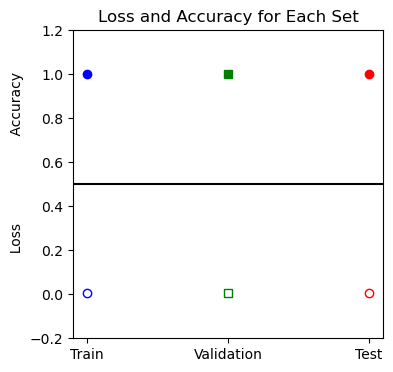

In [22]:
# Creating a figure and axis
fig, ax = plt.subplots(figsize=(4, 4))

# Plotting loss for each set
ax.plot(0, train_loss, marker="o", color="blue", markerfacecolor="white")
ax.plot(1, val_loss, marker="s", color="green", markerfacecolor="white")
ax.plot(2, test_loss, marker="o", color="red", markerfacecolor="white")

# Plotting accuracy for each set
ax.plot(0, train_accuracy, marker="o", color="blue")
ax.plot(1, val_accuracy, marker="s", color="green")
ax.plot(2, test_accuracy, marker="o", color="red")

# Plotting a horizontal line at y=0.5
ax.axhline(y=0.5, color="black", linestyle="-")

# Setting the x-axis ticks and labels
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Train", "Validation", "Test"])

# Setting the y-axis limits and label
ax.set_ylim([-0.2, 1.2])
ax.set_ylabel(f'{"":>10}Loss{"":>20}Accuracy')

# Setting the title and legend
ax.set_title("Loss and Accuracy for Each Set")

# Displaying the plot
plt.show()

For the training and validation sets as well as unseen test set during training, the loss values are all 0.008 and the accuracy values are 1.000, indicating excellent performance and near-perfect generalization of the model.

### Misidentifiers

***Locating errenous predictions***

In [23]:
# Finding the erroneously predicted plates for training set
train_predictions = model.predict(X_train)
train_predicted_labels = np.argmax(train_predictions, axis=-1)
train_actual_labels = np.argmax(y_train_modified, axis=-1)
train_erroneous_indices = np.where(train_predicted_labels != train_actual_labels)[0]

# Finding the erroneously predicted plates for validation set
val_predictions = model.predict(X_val)
val_predicted_labels = np.argmax(val_predictions, axis=-1)
val_actual_labels = np.argmax(y_val_modified, axis=-1)
val_erroneous_indices = np.where(val_predicted_labels != val_actual_labels)[0]

# Finding the erroneously predicted plates for test set
test_predictions = model.predict(X_test)
test_predicted_labels = np.argmax(test_predictions, axis=-1)
test_actual_labels = np.argmax(y_test_modified, axis=-1)
test_erroneous_indices = np.where(test_predicted_labels != test_actual_labels)[0]

1875/1875 [==============================] - 234s 125ms/step


***Demonstrating errenous plates together with their predicted and actual labels***

All the erroneously predicted figures in the training set:


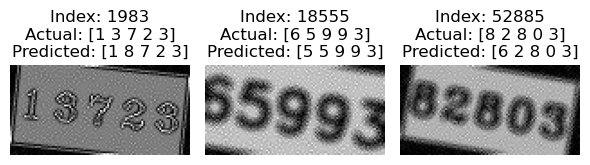

All the erroneously predicted figures in the validation set:


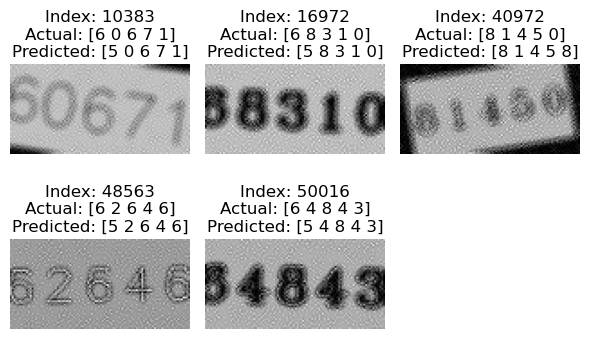

All the erroneously predicted figures in the test set:


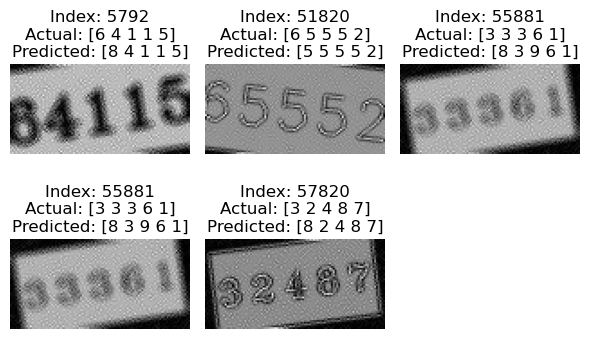

In [24]:
# Iterating over different sets to visualize erroneous predictions
sets = [
    (train_erroneous_indices, train_actual_labels, train_predicted_labels, X_train),
    (val_erroneous_indices, val_actual_labels, val_predicted_labels, X_val),
    (test_erroneous_indices, test_actual_labels, test_predicted_labels, X_test)
]

fig_width = 2  # Width of each figure
num_cols = 3  # Number of columns in the subplot grid

for set_indices, actual_labels, predicted_labels, set_images in sets:
    num_rows = (len(set_indices) + num_cols - 1) // num_cols
    
    # Printing the title for the current set
    if set_indices is train_erroneous_indices:
        print("\033[1mAll the erroneously predicted figures in the training set:\033[0m")
    elif set_indices is val_erroneous_indices:
        print("\033[1mAll the erroneously predicted figures in the validation set:\033[0m")
    elif set_indices is test_erroneous_indices:
        print("\033[1mAll the erroneously predicted figures in the test set:\033[0m")

    # Creating a figure with appropriate size
    plt.figure(figsize=(fig_width * num_cols, fig_width * num_rows))

    for i, index in enumerate(set_indices):
        actual_label = actual_labels[index]  
        predicted_label = predicted_labels[index]  
        figure = set_images[index].numpy().squeeze()  

        # Getting the original height and width of the figure
        original_height, original_width = figure.shape  
        # Calculating the height based on the aspect ratio
        fig_height = fig_width * (original_height / original_width)  

        plt.subplot(num_rows, num_cols, i + 1)  # Create a subplot for the current index
        plt.imshow(figure, cmap='gray')  # Display the figure
        plt.axis('off')  # Turn off the axis
        plt.title(f"Index: {index}\nActual: {actual_label}\nPredicted: {predicted_label}")  # Set the subplot title

    # Adjusting the subplot layout and display the figure
    plt.tight_layout()  
    plt.show()  

***Analysis of misidentifications***

While the model incorrectly estimates only three plate numbers in the training set, there are five instances of misidentified numbers in both the validation and test sets, which contain 60 000 samples each. These misidentifications often occur when dealing with cropped numbers at the figure borders or with too noisy figures. This observation suggests that preprocessing the images using cleaning and augmentation techniques before feeding them to the model can further improve its performance.